# Examine how much the results of AwACI depend on the parameters.

We have two parameters, nu and omega which we can scale. So far it appears that nu needs to be relativley low to avoid the sums getting too large, I hypothesis there is a way of getting around this but am yet to think of it.

It will be interesting to see the affects that a varying sigma has.

## Code to run the experiment.

In [ ]:
import os
import sys
import argparse

import warnings

import numpy as np
import pandas as pd
import yahooquery as yq

warnings.filterwarnings('ignore')

# Import the Conformal Prediction methods
src_path = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots

def get_stock_data(start_index, end_index):
    # Open txt file containg ticker names
    with open(r'C:\Users\tobyw\Documents\ChrisPython\ConformalProject\scripts\snptickers.txt', 'r') as f:
        all_tickers = f.read().splitlines()
        all_tickers.sort()
    
    stock_tickers = all_tickers[start_index:end_index]

    tickers = yq.Ticker(stock_tickers)
    all_price_data = tickers.history(period='5y', interval='1d')
    price_df = all_price_data[['close']].copy()

    stock_data_tuples = []

    # Some tickers in the list are incorrect or not trading so need 

    for ticker_symbol in price_df.index.get_level_values(0).unique():
        # Getting the volatilty data for each ticker
        ticker_price_data = price_df.loc[ticker_symbol]
        ticker_close = ticker_price_data['close'].to_numpy()

        # As when creating the volaility there is an intial NaN value, I will remove this.
        ticker_close = ticker_close[1:]

        # Appending it to the stock_data_tuples list, the last volatilty is used as the prediciton for the next.
        stock_data_tuples.append((ticker_symbol, (ticker_close[:-1], ticker_close[1:])))
    

    return stock_data_tuples

def run_conformal_prediction(conformal_data: dict, stock_data: list, alpha: float, method: str, startpoint=550):

    # intialise Adative CP
    ACP = AdaptiveCP(alpha, 100)


    for i, (ticker_symbol, data) in enumerate(stock_data, start=conformal_data['next']):
        # Run the conformal prediction method on the data

        method_result = ACP.AwACI(data)

        # Calculate the coverage and width of the intervals
        average_coverage = method_result['realised_interval_coverage']
        average_prediction_interval = method_result['average_prediction_interval']

        individual_prediction_widths = list(map(lambda x: x[1] - x[0], method_result['conformal_sets']))

        # Calculate the quantiles of the width
        Qwidth1 = np.nanquantile(individual_prediction_widths, 0.01)
        Qwidth25 = np.nanquantile(individual_prediction_widths, 0.25)
        Qwidth50 = np.nanquantile(individual_prediction_widths, 0.5)
        Qwidth75 = np.nanquantile(individual_prediction_widths, 0.75)
        Qwidth99 = np.nanquantile(individual_prediction_widths, 0.99)

        # Add the results to the output
        conformal_data['individual_results'].append({
            'ticker': ticker_symbol,
            'coverage': average_coverage,
            'width': average_prediction_interval,
            'Qwidth1': Qwidth1,
            'Qwidth25': Qwidth25,
            'Qwidth50': Qwidth50,
            'Qwidth75': Qwidth75,
            'Qwidth99': Qwidth99
        })

        # Log the point

        # Update the current index
        conformal_data['next'] = i

 
if __name__ == '__main__':


    # Load the checkpoint
    if args.resume:
        conformal_data = load_checkpoint(args.resume)
        logging.info('Resuming from checkpoint')
    else:
        conformal_data = {
            'next': 0,
            'target': args.datapoints,
            'individual_results': []
            }
        logging.info('Created data dictionary', conformal_data)

    # Get the stock data
    stock_data = get_stock_data(conformal_data['next'], conformal_data['target'])

    # Run the conformal prediction
    run_conformal_prediction(conformal_data, stock_data, args.alpha, args.method)

    # Save the results
    
    # Compute averages of each key in the individual results
    averages = {}
    for key in list(conformal_data['individual_results'][0].keys())[1:]:
        averages[key] = np.nanmean([x[key] for x in conformal_data['individual_results']])


## Getting the stock data

In [2]:
import os
import sys
import argparse

import warnings

import numpy as np
import pandas as pd
import yahooquery as yq

warnings.filterwarnings('ignore')

# Import the Conformal Prediction methods
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots

def get_stock_data(start_index, end_index):
    # Open txt file containg ticker names
    with open(r'C:\Users\tobyw\Documents\ChrisPython\ConformalProject\scripts\snptickers.txt', 'r') as f:
        all_tickers = f.read().splitlines()
        all_tickers.sort()
    
    stock_tickers = all_tickers[start_index:end_index]

    tickers = yq.Ticker(stock_tickers)
    all_price_data = tickers.history(period='5y', interval='1d')
    price_df = all_price_data[['close']].copy()

    stock_data_tuples = []

    # Some tickers in the list are incorrect or not trading so need 

    for ticker_symbol in price_df.index.get_level_values(0).unique():
        # Getting the volatilty data for each ticker
        ticker_price_data = price_df.loc[ticker_symbol]
        ticker_close = ticker_price_data['close'].to_numpy()

        # As when creating the volaility there is an intial NaN value, I will remove this.
        ticker_close = ticker_close[1:]

        # Appending it to the stock_data_tuples list, the last volatilty is used as the prediciton for the next.
        stock_data_tuples.append((ticker_symbol, (ticker_close[:-1], ticker_close[1:])))
    

    return stock_data_tuples

In [33]:
stock_data = get_stock_data(0, 100)

# Code for running the experiments

In [34]:
sigmas = np.linspace(0.05, 0.5, 10)

In [35]:
def run_experimemt(stock_data, target, mu, sigma):
    width_results = []
    coverage_results = []

    ACP = AdaptiveCP(target)

    for data in stock_data:
        result = ACP.AwACI(data[1], nu_sigma=(mu, sigma))
        width_results.append(result['average_prediction_interval'])
        coverage_results.append(result['realised_interval_coverage'])

    return np.nanmean(width_results), np.nanmean(coverage_results)

In [36]:
print(run_experimemt(stock_data, 0.1, 0.05, 0.5))

(np.float64(11.256781821592062), np.float64(0.8966843690099268))


In [37]:
sigmas = np.linspace(0.05, 0.9, 10)
for sigma in sigmas:
    print(f'{round(sigma,2)} the result is {run_experimemt(stock_data, 0.1, 0.05, sigma)}')

0.05 the result is (np.float64(11.225004803821818), np.float64(0.8961706432134663))
0.14 the result is (np.float64(11.254799701514214), np.float64(0.8975399859143749))
0.24 the result is (np.float64(11.273421125457428), np.float64(0.8969400271991077))
0.33 the result is (np.float64(11.279694694452203), np.float64(0.8973834920430174))
0.43 the result is (np.float64(11.26228604079275), np.float64(0.8968749625098217))
0.52 the result is (np.float64(11.278152255143103), np.float64(0.8972300333661427))
0.62 the result is (np.float64(11.270085112190813), np.float64(0.8974783962187164))
0.71 the result is (np.float64(11.28290303639357), np.float64(0.8967117078139859))
0.81 the result is (np.float64(11.293266792297496), np.float64(0.8973309475599017))
0.9 the result is (np.float64(11.26883908455208), np.float64(0.8972067011817989))


In [38]:
nus = np.linspace(10**-10, 10**-1, 10)
for nu in nus:
    print(f'{round(sigma,2)} the result is {run_experimemt(stock_data, 0.1, nu, 0.05)}')

0.9 the result is (np.float64(11.287368018580976), np.float64(0.8964454090166895))
0.9 the result is (np.float64(11.27910514442072), np.float64(0.8973136944453369))


KeyboardInterrupt: 

In [ ]:
nus = np.linspace(10**-1, 0, 10)
for nu in nus:
    print(f'{round(nu,2)} the result is {run_experimemt(stock_data, 0.1, nu, 0.05)}')

0.1 the result is (np.float64(10.198570394859976), np.float64(0.8959763214416678))
0.09 the result is (np.float64(10.20729076622349), np.float64(0.8975317722248416))
0.08 the result is (np.float64(10.181973806946989), np.float64(0.8953176698622244))
0.07 the result is (np.float64(10.184956364178275), np.float64(0.8953925821153543))
0.06 the result is (np.float64(10.213065816980366), np.float64(0.8975843941537012))
0.04 the result is (np.float64(10.206407565224563), np.float64(0.897569568861648))
0.03 the result is (np.float64(10.217514951477243), np.float64(0.8979223374718422))
0.02 the result is (np.float64(10.23014639810037), np.float64(0.8981178689297501))
0.01 the result is (np.float64(10.227011530663802), np.float64(0.8972795065220808))
0.0 the result is (np.float64(10.192421941921758), np.float64(0.8958608098905128))


In [ ]:
nus = np.linspace(10**-5, 10**-1, 10)
for nu, sigma in zip(nus, sigmas):
    print(f'{round(nu,2)} {round(sigma, 2)} the result is {run_experimemt(stock_data, 0.4, nu, sigma)}')

0.0 0.05 the result is (np.float64(4.777032031456589), np.float64(0.5987836188380743))
0.01 0.1 the result is (np.float64(4.780922576738578), np.float64(0.6018107024988213))
0.02 0.15 the result is (np.float64(4.776906765919119), np.float64(0.5976812300277646))
0.03 0.2 the result is (np.float64(4.777630298819101), np.float64(0.5982462936769867))
0.04 0.25 the result is (np.float64(4.782054995538223), np.float64(0.5992896432500393))
0.06 0.3 the result is (np.float64(4.786011650755535), np.float64(0.6017031798417936))
0.07 0.35 the result is (np.float64(4.780773890238924), np.float64(0.5984056786631045))
0.08 0.4 the result is (np.float64(4.776413196421306), np.float64(0.5988229346744198))
0.09 0.45 the result is (np.float64(4.7744207893016775), np.float64(0.6002495154277333))
0.1 0.5 the result is (np.float64(4.773803191833946), np.float64(0.5990622609880034))


 It appears that the tuning makes essentialy no differnce which seems very odd, especially for the sigma.

If this is the case then it would suggest that the method is adding relativley little value to the prediction.

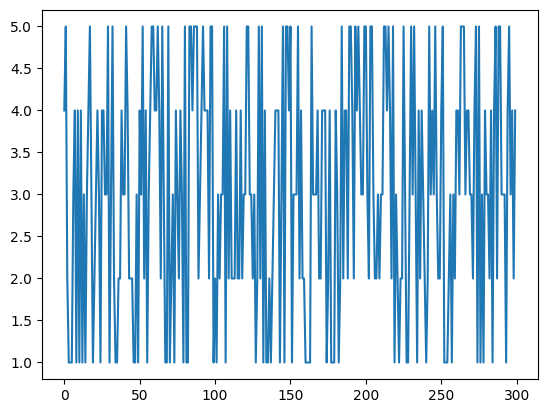

In [41]:
import matplotlib.pyplot as plt
a = np.random.randint(1, 6, 300)
plt.plot(a)
plt.show()

This has made me strongly believe that it is just choosimg randomly, this would explain why it is only marginly better. The way to fix this may will lye in the loss function. It is probably the case that this is either too sensitive to small changes or in the worst case the heads do not perform consistently different enough.